In [14]:
import time
import glob as glob
import torch
import cv2
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from config import DEVICE, NUM_CLASSES, NUM_EPOCHS , OUT_DIR , RESIZE_TO, CLASSES
from model import create_model
from utils import Averager
from datasets import train_loader, valid_loader,visualize_batch

In [2]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for _, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        anchor = model(images, targets)
        positive = model(images, targets)
        negative = model(images, targets)

        anchor_loss = sum(loss for loss in anchor.values())
        positive_loss = sum(loss for loss in positive.values())
        negative_loss = sum(loss for loss in negative.values())

        losses = criterion(anchor_loss, positive_loss, negative_loss)
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [3]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for _, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            anchor_valid = model(images, targets)
            positive_valid = model(images, targets)
            negative_valid = model(images, targets)


        anchor_valid_loss = sum(loss for loss in anchor_valid.values())
        positive_valid_loss = sum(loss for loss in positive_valid.values())
        negative_valid_loss = sum(loss for loss in negative_valid.values())

        losses = criterion(anchor_valid_loss, positive_valid_loss, negative_valid_loss)
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

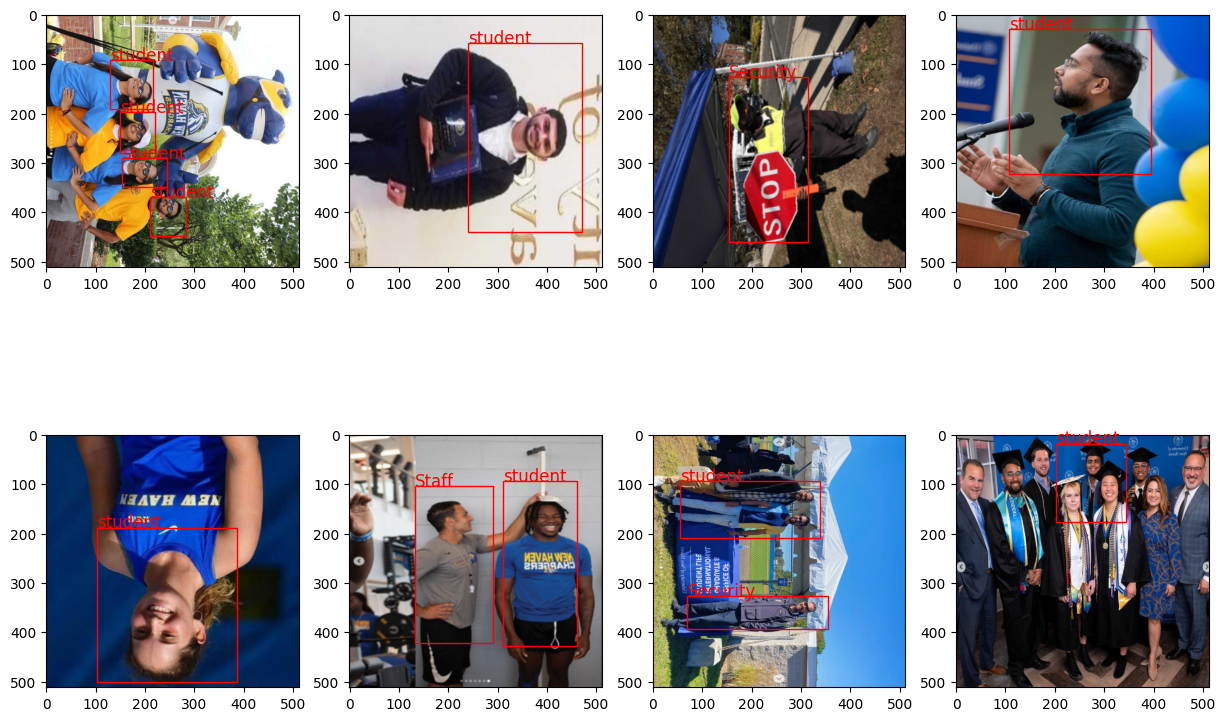

In [4]:
#Visualize batch of images

images, targets = next(iter(train_loader))

visualize_batch(images,targets)

In [5]:
# Model initialization and setup
model = create_model(num_classes=NUM_CLASSES).to(DEVICE)

# Get parameters that require gradient
params = [p for p in model.parameters() if p.requires_grad]

# Define loss function and optimizer
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=0.01, swap=False, reduction='mean')
optimizer = torch.optim.SGD(params, lr=1e-4, momentum=0.1, weight_decay=5e-5)

# Initialize loss trackers
train_loss_hist = Averager()
val_loss_hist = Averager()

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# Initialize loss lists
train_loss_list = []
val_loss_list = []

train_losses = []
val_losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset loss histories
    train_loss_hist.reset()
    val_loss_hist.reset()

    # Time the training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    train_losses.append(train_loss_hist.value)
    val_losses.append(val_loss_hist.value)
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")


training = 'done'


EPOCH 1 of 20
Training


Loss: 0.0105: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Validating


Loss: 0.0111: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #1 train loss: 0.011
Epoch #1 validation loss: 0.010
Took 0.533 minutes for epoch 1

EPOCH 2 of 20
Training


Loss: 0.0049: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Validating


Loss: 0.0200: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch #2 train loss: 0.011
Epoch #2 validation loss: 0.012
Took 0.521 minutes for epoch 2

EPOCH 3 of 20
Training


Loss: 0.0033: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.0000: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch #3 train loss: 0.011
Epoch #3 validation loss: 0.006
Took 0.505 minutes for epoch 3

EPOCH 4 of 20
Training


Loss: 0.0101: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.0165: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch #4 train loss: 0.012
Epoch #4 validation loss: 0.016
Took 0.509 minutes for epoch 4

EPOCH 5 of 20
Training


Loss: 0.0096: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.0086: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #5 train loss: 0.010
Epoch #5 validation loss: 0.005
Took 0.506 minutes for epoch 5

EPOCH 6 of 20
Training


Loss: 0.0002: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0010: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #6 train loss: 0.007
Epoch #6 validation loss: 0.006
Took 0.499 minutes for epoch 6

EPOCH 7 of 20
Training


Loss: 0.0071: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.0103: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #7 train loss: 0.009
Epoch #7 validation loss: 0.007
Took 0.510 minutes for epoch 7

EPOCH 8 of 20
Training


Loss: 0.0134: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0000: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #8 train loss: 0.009
Epoch #8 validation loss: 0.009
Took 0.500 minutes for epoch 8

EPOCH 9 of 20
Training


Loss: 0.0097: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.0293: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #9 train loss: 0.010
Epoch #9 validation loss: 0.018
Took 0.506 minutes for epoch 9

EPOCH 10 of 20
Training


Loss: 0.0000: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Validating


Loss: 0.0096: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch #10 train loss: 0.009
Epoch #10 validation loss: 0.012
Took 0.495 minutes for epoch 10

EPOCH 11 of 20
Training


Loss: 0.0135: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.0022: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #11 train loss: 0.012
Epoch #11 validation loss: 0.002
Took 0.505 minutes for epoch 11

EPOCH 12 of 20
Training


Loss: 0.0052: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0001: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch #12 train loss: 0.010
Epoch #12 validation loss: 0.007
Took 0.500 minutes for epoch 12

EPOCH 13 of 20
Training


Loss: 0.0197: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0154: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #13 train loss: 0.012
Epoch #13 validation loss: 0.010
Took 0.500 minutes for epoch 13

EPOCH 14 of 20
Training


Loss: 0.0175: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.0043: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #14 train loss: 0.008
Epoch #14 validation loss: 0.009
Took 0.506 minutes for epoch 14

EPOCH 15 of 20
Training


Loss: 0.0133: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.0000: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #15 train loss: 0.009
Epoch #15 validation loss: 0.009
Took 0.508 minutes for epoch 15

EPOCH 16 of 20
Training


Loss: 0.0156: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.0007: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #16 train loss: 0.009
Epoch #16 validation loss: 0.006
Took 0.504 minutes for epoch 16

EPOCH 17 of 20
Training


Loss: 0.0065: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0055: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #17 train loss: 0.010
Epoch #17 validation loss: 0.006
Took 0.501 minutes for epoch 17

EPOCH 18 of 20
Training


Loss: 0.0168: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0000: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #18 train loss: 0.009
Epoch #18 validation loss: 0.012
Took 0.501 minutes for epoch 18

EPOCH 19 of 20
Training


Loss: 0.0233: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.0000: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #19 train loss: 0.011
Epoch #19 validation loss: 0.006
Took 0.506 minutes for epoch 19

EPOCH 20 of 20
Training


Loss: 0.0000: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Validating


Loss: 0.0150: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

Epoch #20 train loss: 0.008
Epoch #20 validation loss: 0.010
Took 0.514 minutes for epoch 20


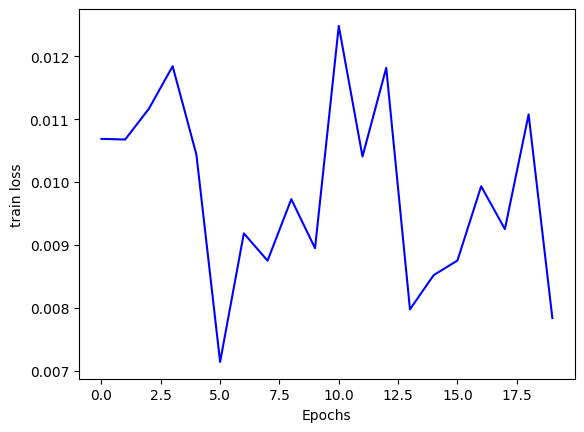

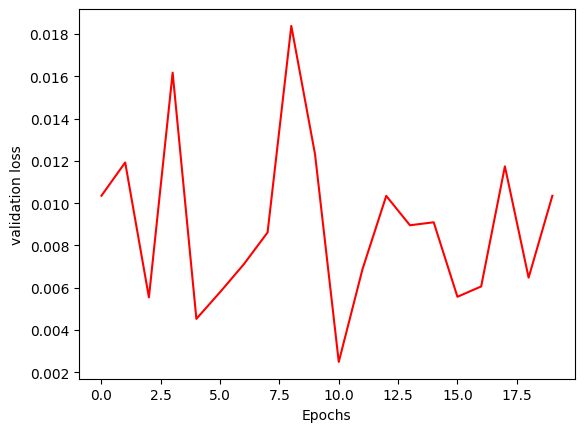

In [6]:
figure_1, train_ax = plt.subplots()
figure_2, valid_ax = plt.subplots()
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
# save the model and plots after training

if training == 'done': 
    train_ax.plot(train_losses, color='blue')
    train_ax.set_xlabel('Epochs')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_losses, color='red')
    valid_ax.set_xlabel('Epochs')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")

    torch.save(model.state_dict(), f"{OUT_DIR}/model.pth")

Test instances: 20


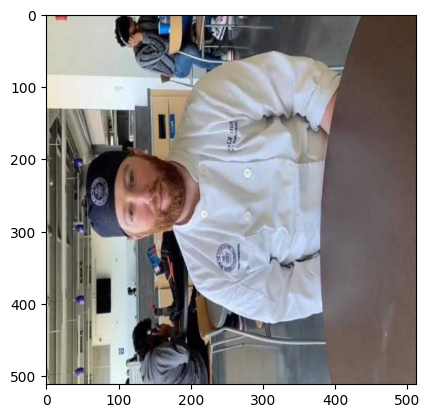

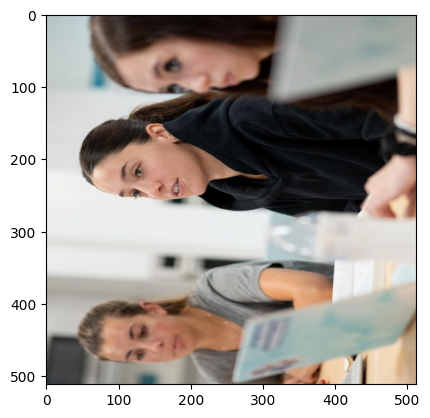

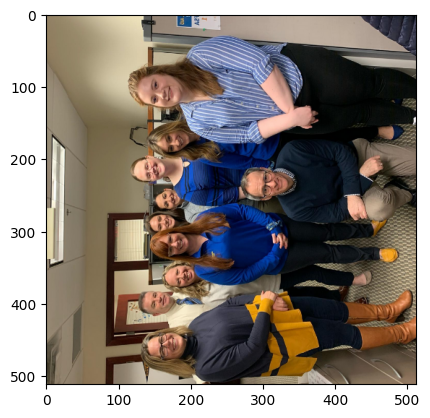

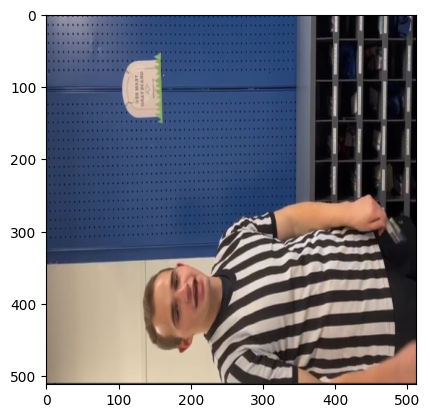

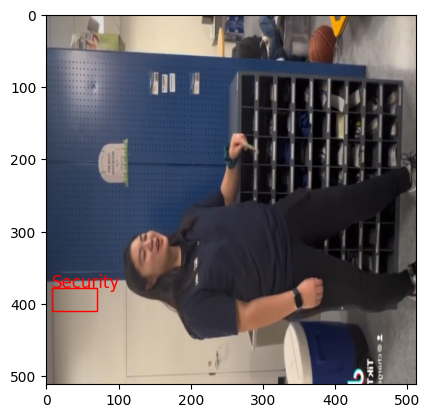

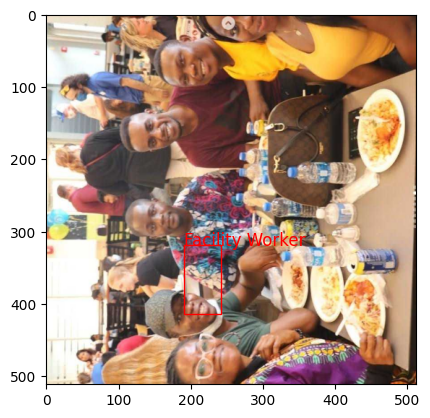

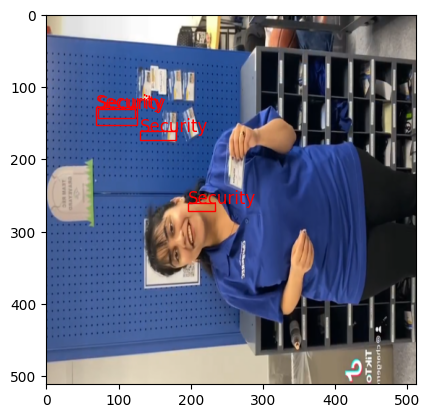

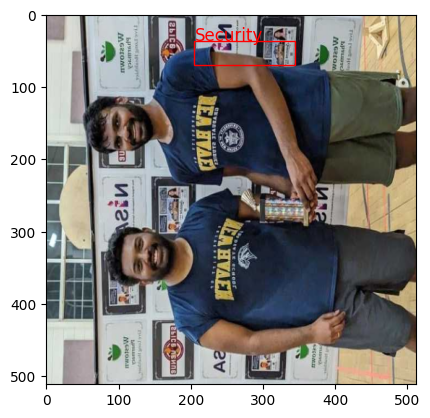

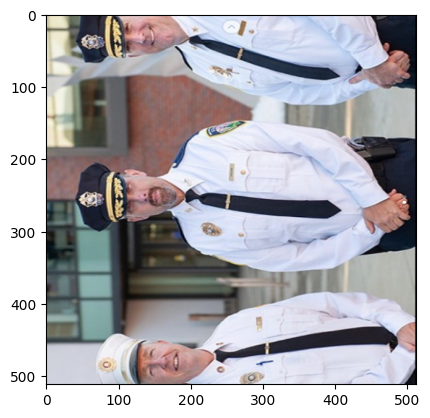

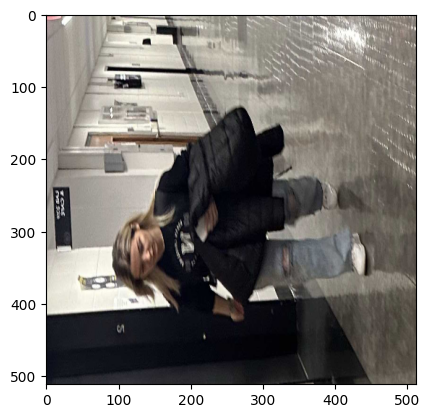

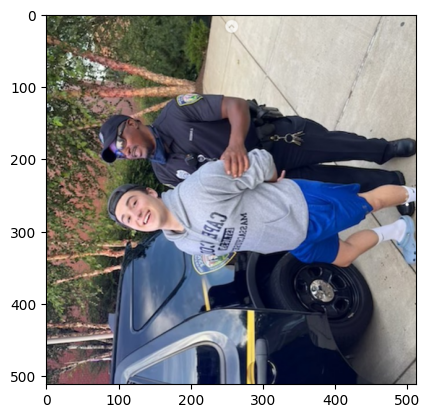

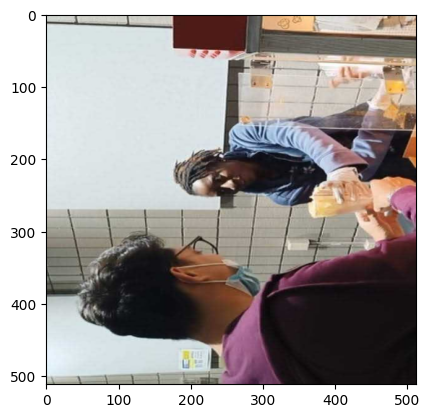

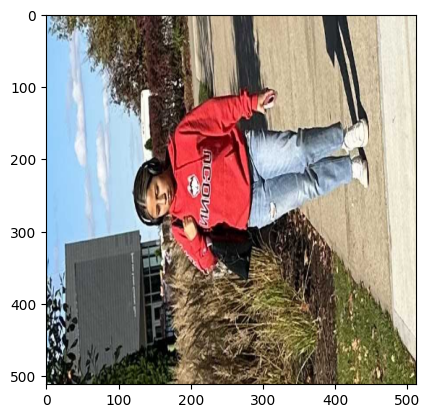

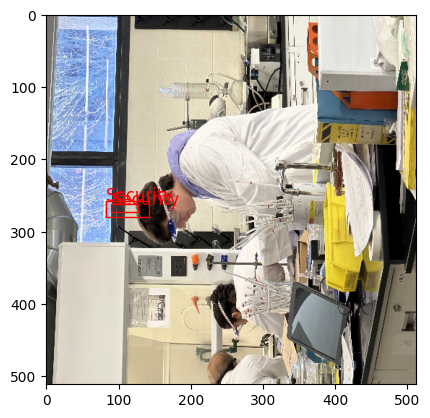

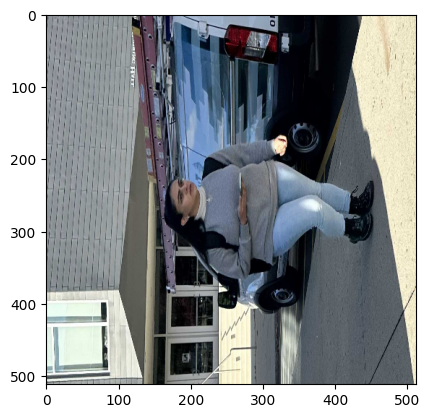

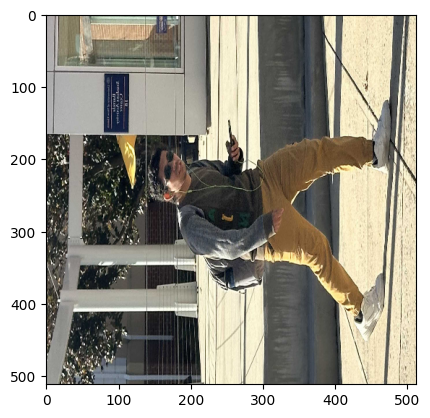

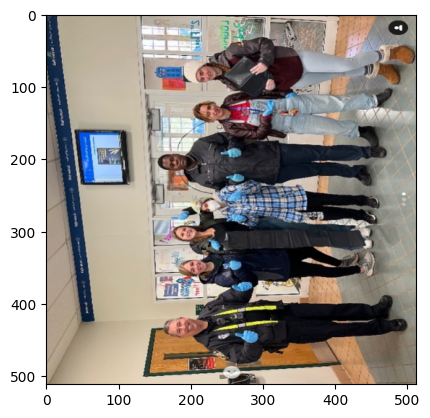

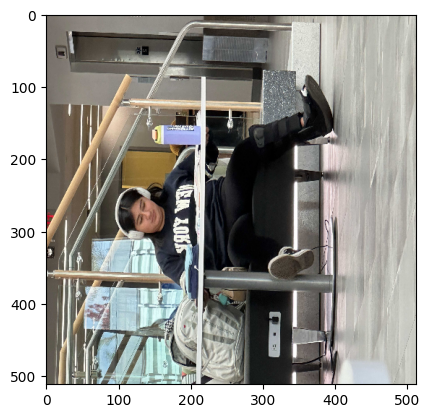

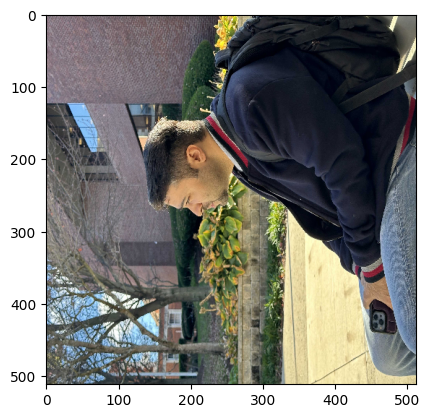

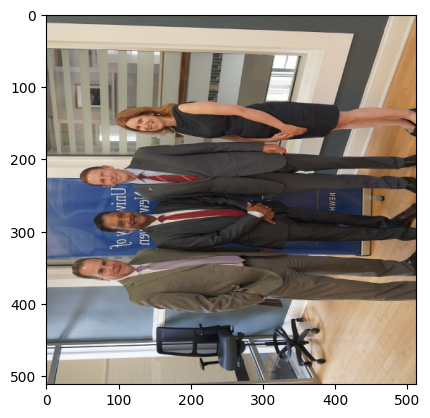

In [18]:
model.eval()
  
DIR_TEST = 'dataset/test'
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

# test_images = test_images[6]

for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    # print(image_name)
    image = cv2.imread(test_images[i])
    # print(image)
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # resize to the model input size
    image = cv2.resize(image, (RESIZE_TO, RESIZE_TO))
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # print(scores)
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= 0.45].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        # print(pred_classes)

        fig, axs = plt.subplots()
        
        image = image.permute(0, 3, 2, 1).cpu().numpy()
        image = image.squeeze()
        axs.imshow(image)
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red')
            axs.add_patch(rect)
            axs.text(x1, y1, pred_classes[j], fontsize=12, color='red')

        plt.show()